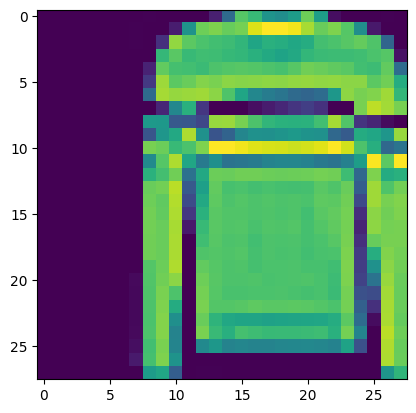

<class 'torch.Tensor'> <class 'torch.Tensor'>
torch.Size([60000, 28, 28]) torch.Size([60000])
torch.Size([10000, 28, 28]) torch.Size([10000])
cuda


In [ ]:
import torch
from torchvision import datasets
from torch.utils.data import Dataset, DataLoader
from torchvision.transforms import transforms
import torch.nn as nn
from torchsummary import summary
from torch.optim import SGD
import matplotlib.pyplot as plt
from torch.optim import Adam
import numpy as np
import time

device = 'cuda' if torch.cuda.is_available() else 'cpu'

transform_train = transforms.Compose([
                           transforms.RandomAffine(0, translate=(0.5, 0)),
                           transforms.ToTensor()])

fmnist_train = datasets.FashionMNIST('~/data/FMNIST', download=True, train=True, transform=transform_train)
fmnist_test = datasets.FashionMNIST('~/data/FMNIST', download=True, train=False)
x_train, y_train = fmnist_train.data, fmnist_train.targets
x_test, y_test = fmnist_test.data, fmnist_test.targets

class FMNISTDataset(Dataset):
   def __init__(self, x, y):
       x = x.view(-1, 1, 28, 28)
       x = x.float()/255
       self.shift = transforms.RandomAffine(0, translate=(0.5, 0))
       self.x, self.y = x, y
   def __getitem__(self, ix):
       x = self.x[ix]
       x = self.shift(x)
       return x.to(device), self.y[ix].to(device)
   def __len__(self):
       return len(self.x)


train_dataset = FMNISTDataset(x_train, y_train)
train_dl = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_dataset = FMNISTDataset(x_test, y_test)
test_dl = DataLoader(test_dataset, batch_size=64, shuffle=True)

plt.imshow(train_dataset[5][0].cpu()[0, :, :])
plt.show()
print(type(x_train), type(y_train))
print(x_train.shape, y_train.shape)
print(x_test.shape, y_test.shape)
print(device)


#class CNN

In [ ]:
class MLP(nn.Module):

  def __init__(self, output_classes=10, units_per_layer=100):
    super().__init__()

    self.units_per_layer = units_per_layer
    self.output_classes = output_classes

    self.linear_stack = nn.Sequential(
        nn.Flatten(),
        nn.Linear(28 * 28, units_per_layer),
        nn.Linear(units_per_layer, units_per_layer),
        nn.Linear(units_per_layer, units_per_layer),
        nn.Linear(units_per_layer, units_per_layer),
        nn.Linear(units_per_layer, units_per_layer),
        nn.Linear(units_per_layer, 10),
    )

  def forward(self, x):
    x = self.linear_stack(x)
    return x

  def num_parameters(self):
    """Gets number of parameters"""
    return sum(p.numel() for p in self.parameters() if p.requires_grad)

  def train_batch(self, X_train, Y_train, opt, loss):
    self.train()
    opt.zero_grad()                    # Flush memory
    pred = self(X_train)
    batch_loss = loss(pred, Y_train)   # Compute loss
    batch_loss.backward()              # Compute gradients
    opt.step()                         # Make a GD step

    return batch_loss.detach().cpu().numpy()

  @torch.no_grad()
  def accuracy(self, x, y):
    self.eval()

    prediction = self(x)
    argmaxes = prediction.argmax(dim=1)
    s = torch.sum((argmaxes == y).float())/len(y)

    return s.cpu().numpy()



In [ ]:
class CNN(nn.Module):
  def __init__(self, channels=1, output_classes=10, num_filters=10, kernel_size=3, pool_size=2):
    super().__init__()

    self.loss_func = nn.CrossEntropyLoss()
    self.feature_stack = nn.Sequential(
      nn.Conv2d(channels,num_filters, kernel_size),
      nn.MaxPool2d(pool_size),
      nn.ReLU(),
      nn.Conv2d(num_filters, num_filters, kernel_size),
      nn.MaxPool2d(pool_size),
      nn.ReLU(),
    )

    # 1st conv layer
    new_dim = 28 - (kernel_size - 1)
    # max pool
    new_dim = new_dim // pool_size
    # 2nd conv layer
    new_dim = new_dim - (kernel_size - 1)
    # max pool
    new_dim = new_dim // pool_size
    # Flatten
    total_new_dimensions = num_filters * (new_dim ** 2)

    self.classification_stack = nn.Sequential(
      nn.Flatten(),
      nn.Linear(total_new_dimensions, 200), nn.ReLU(),
      nn.Linear(200, output_classes)
    )

  def forward(self, x):
    x = self.feature_stack(x)
    x = self.classification_stack(x)
    return x

  def num_parameters(self):
    """Gets number of parameters"""
    self.train()
    return sum(p.numel() for p in self.parameters() if p.requires_grad)

  def train_batch(self, X_train, Y_train, opt, loss_func):
    self.train()

    opt.zero_grad()                       # Flush memory
    pred = self(X_train)
    batch_loss = loss_func(pred, Y_train) # Compute loss
    batch_loss.backward()                 # Compute gradients
    opt.step()                            # Make a GD step

    return batch_loss.detach().cpu().numpy()

  @torch.no_grad()
  def accuracy(self, x, y):
    self.eval()

    prediction = self(x)
    argmaxes = prediction.argmax(dim=1)
    s = torch.sum((argmaxes == y).float())/len(y)

    return s.cpu().numpy()


In [ ]:
def plot(data1, data2, data3, title1, title2, xlabel, ylabel1, ylabel2):
  fig, axs = plt.subplots(1, 2, figsize=(12, 4))  # Create a 1x2 grid of subplots

  axs[0].plot(data1)
  axs[0].set_title(title1)
  axs[0].set_xlabel(xlabel)
  axs[0].set_ylabel(ylabel1)

  axs[1].plot(data2, label="Train Accuracy")
  axs[1].set_title(title2)
  axs[1].set_xlabel(xlabel)
  axs[1].set_ylabel(ylabel2)

  axs[1].plot(data3, label="Test Accuracy")

  axs[1].legend()

  plt.show()

In [ ]:


def train_model(model, epochs, optimizer, loss):

  losses, is_accuracies, os_accuracies, n_epochs = [], [], [], epochs
  start = time.time()
  for epoch in range(n_epochs):
      print(f"Running epoch {epoch + 1} of {n_epochs}")
      epoch_is_accuracies, epoch_os_accuracies = [], []
      epoch_losses = []

      # Loop to train each batch and measure its loss value
      for i, batch in enumerate(train_dl):
          x, y = batch
          batch_loss = model.train_batch(x, y, optimizer, loss)
          epoch_losses.append(batch_loss)
      epoch_loss = np.mean(epoch_losses)

      # Loop to measure the batch's accuracy
      for batch in train_dl:
          x, y = batch
          batch_acc = model.accuracy(x, y)
          epoch_is_accuracies.append(batch_acc)
      epoch_is_accuracy = np.mean(epoch_is_accuracies)

      # Get out of sample accuracy
      for batch in test_dl:
        x, y = batch
        batch_acc = model.accuracy(x, y)
        epoch_os_accuracies.append(batch_acc)
      epoch_os_accuracy = np.mean(epoch_os_accuracies)

      losses.append(epoch_loss)
      is_accuracies.append(epoch_is_accuracy)
      os_accuracies.append(epoch_os_accuracy)

  training_time = time.time() - start
  return losses, is_accuracies, os_accuracies, training_time

Running epoch 1 of 5
Running epoch 2 of 5
Running epoch 3 of 5
Running epoch 4 of 5
Running epoch 5 of 5


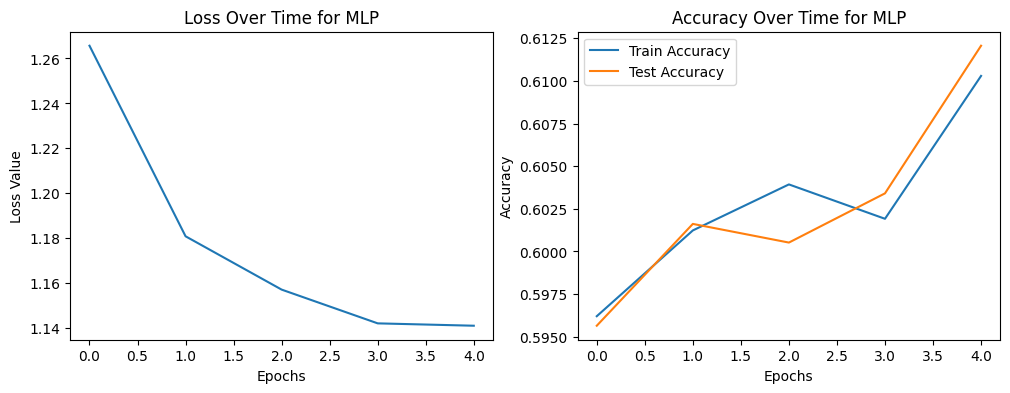

Run time: 378.53373765945435
MLP Parameters: 319810
CNN: [0.7639331, 0.80782247, 0.82663214, 0.8489252, 0.839371]
MLP: [0.5961987, 0.60122937, 0.6039279, 0.6019123, 0.6102912]


In [ ]:
# Part a

# CNN
cnn_model = CNN(channels=1, num_filters=64).to(device)
loss_func = nn.CrossEntropyLoss().to(device)
opt = Adam(cnn_model.parameters(), lr=1e-3)
losses, is_accuracies, os_accuracies, run_time = train_model(cnn_model, 5, opt, loss_func)
plot(losses, is_accuracies, os_accuracies,
     f"Loss Over Time for CNN",
     f"Accuracy Over Time for CNN",
     "Epochs",
     "Loss Value",
     "Accuracy"
)
print(f"Run time: {run_time}")
print(f"CNN Parameters: {cnn_model.num_parameters()}")

# MLP
mlp_model = MLP(units_per_layer=200).to(device)
loss_func = nn.CrossEntropyLoss().to(device)
opt = Adam(mlp_model.parameters(), lr=1e-3)
losses, is_accs, os_accs, run_time = train_model(mlp_model, 5, opt, loss_func)
plot(losses, is_accs, os_accs,
     f"Loss Over Time for MLP",
     f"Accuracy Over Time for MLP",
     "Epochs",
     "Loss Value",
     "Accuracy"
)
print(f"Run time: {run_time}")
print(f"MLP Parameters: {mlp_model.num_parameters()}")

print(f"CNN: {os_accuracies}")
print(f"MLP: {os_accs}")


Running epoch 1 of 5
Running epoch 2 of 5
Running epoch 3 of 5
Running epoch 4 of 5
Running epoch 5 of 5
Total training time for Kernel Size 2: 390.16540265083313
Number of parameters: 74670
Test accuracies: [0.69088376, 0.72193474, 0.75467753, 0.77577627, 0.78005576]


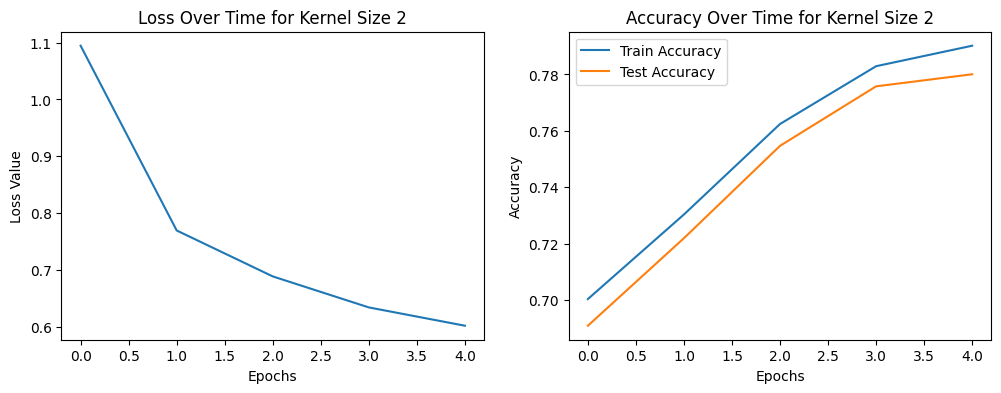

Running epoch 1 of 5
Running epoch 2 of 5
Running epoch 3 of 5
Running epoch 4 of 5
Running epoch 5 of 5
Total training time for Kernel Size 3: 387.309855222702
Number of parameters: 53220
Test accuracies: [0.7214371, 0.75378186, 0.75726515, 0.78851515, 0.77965766]


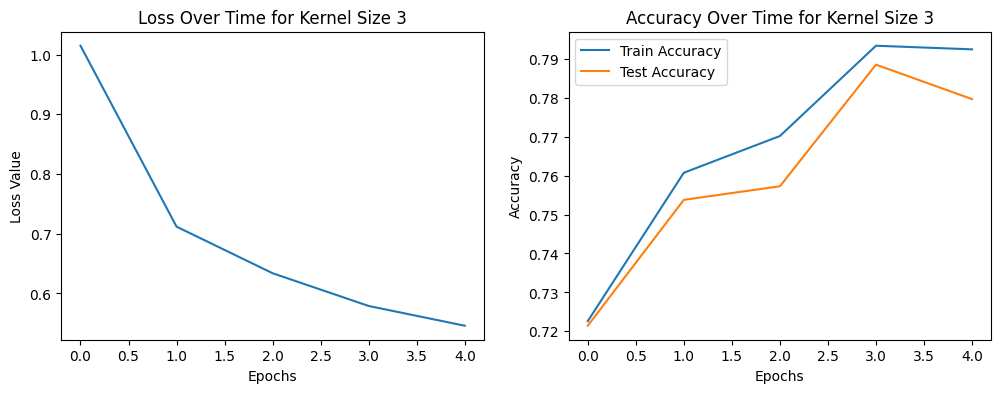

Running epoch 1 of 5
Running epoch 2 of 5
Running epoch 3 of 5
Running epoch 4 of 5
Running epoch 5 of 5
Total training time for Kernel Size 5: 391.025066614151
Number of parameters: 36980
Test accuracies: [0.7056131, 0.7534833, 0.78334, 0.7977707, 0.8112062]


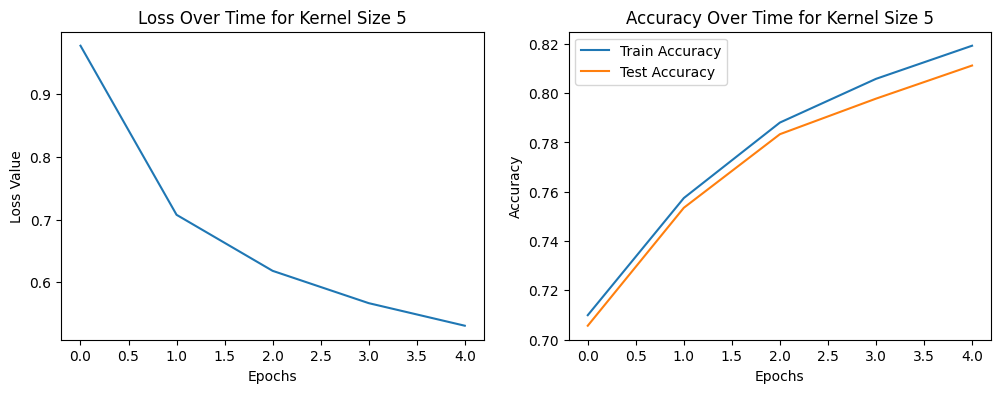

Running epoch 1 of 5
Running epoch 2 of 5
Running epoch 3 of 5
Running epoch 4 of 5
Running epoch 5 of 5
Total training time for Kernel Size 7: 389.1667785644531
Number of parameters: 15620
Test accuracies: [0.6727707, 0.6799363, 0.7191481, 0.7137739, 0.734574]


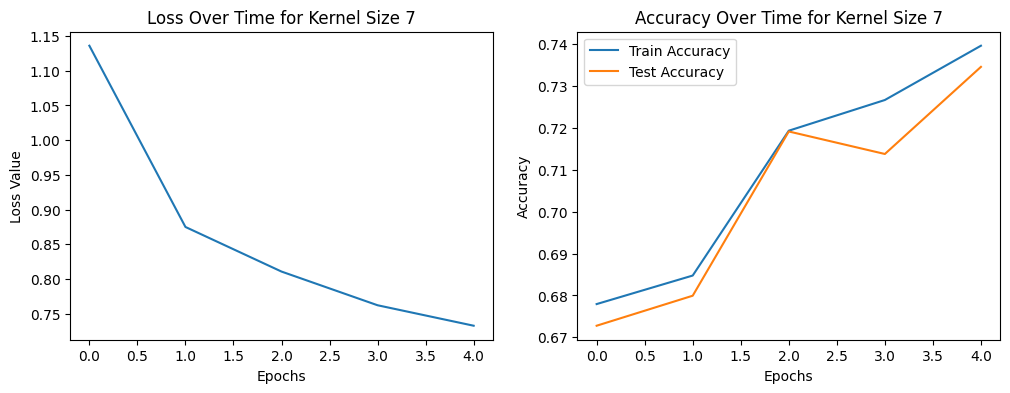

Running epoch 1 of 5
Running epoch 2 of 5
Running epoch 3 of 5
Running epoch 4 of 5
Running epoch 5 of 5
Total training time for Kernel Size 9: 393.45627331733704
Number of parameters: 13140
Test accuracies: [0.714371, 0.7483081, 0.75826037, 0.7816481, 0.78901273]


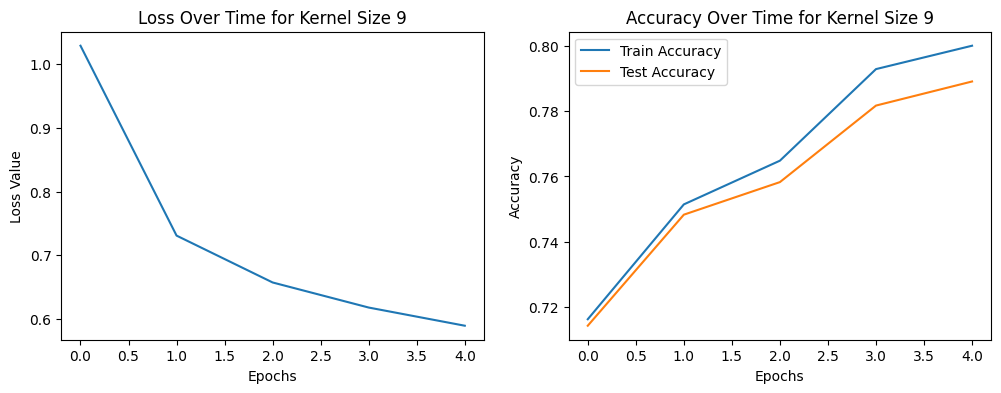

In [ ]:
# Part b
# For a fixed number of layers and filters in CNN, vary kernel size from 2, 3, 5, 7, 9 and compare the performance of the model and the training time.

for size in [2, 3, 5, 7, 9]:
  model = CNN(kernel_size=size).to(device)
  loss_func = nn.CrossEntropyLoss().to(device)
  opt = Adam(model.parameters(), lr=1e-3)
  losses, is_accs, os_accs, training_time = train_model(model, 5, opt, loss_func)

  print(f"Total training time for Kernel Size {size}: {training_time}")
  print(f"Number of parameters: {model.num_parameters()}")
  print(f"Test accuracies: {os_accs}")
  plot(losses, is_accs, os_accs,
       f"Loss Over Time for Kernel Size {size}",
       f"Accuracy Over Time for Kernel Size {size}",
       "Epochs", "Loss Value", "Accuracy"
  )


Running epoch 1 of 5
Running epoch 2 of 5
Running epoch 3 of 5
Running epoch 4 of 5
Running epoch 5 of 5
Total training time for Filter Size 15: 393.82827949523926
Number of parameters: 79400
Test accuracies: [0.71088773, 0.7730892, 0.7843352, 0.8061306, 0.81279856]


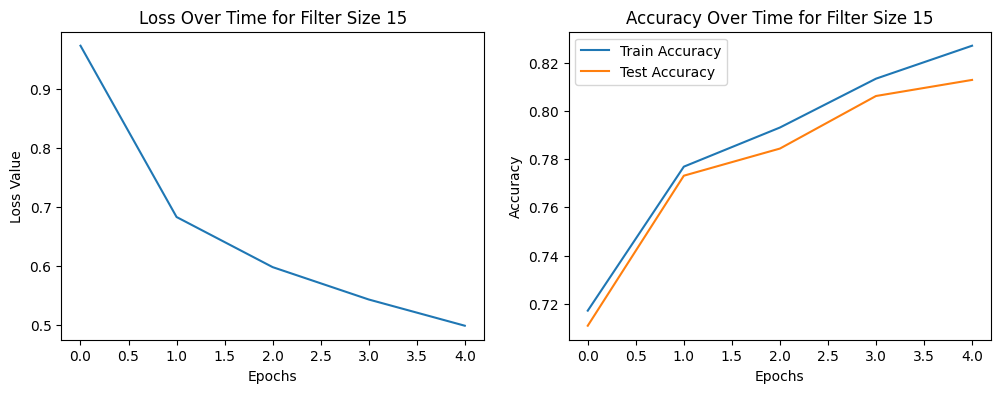

Running epoch 1 of 5
Running epoch 2 of 5
Running epoch 3 of 5
Running epoch 4 of 5
Running epoch 5 of 5
Total training time for Filter Size 20: 393.6997244358063
Number of parameters: 106030
Test accuracies: [0.7308917, 0.7719944, 0.803543, 0.81946653, 0.8242436]


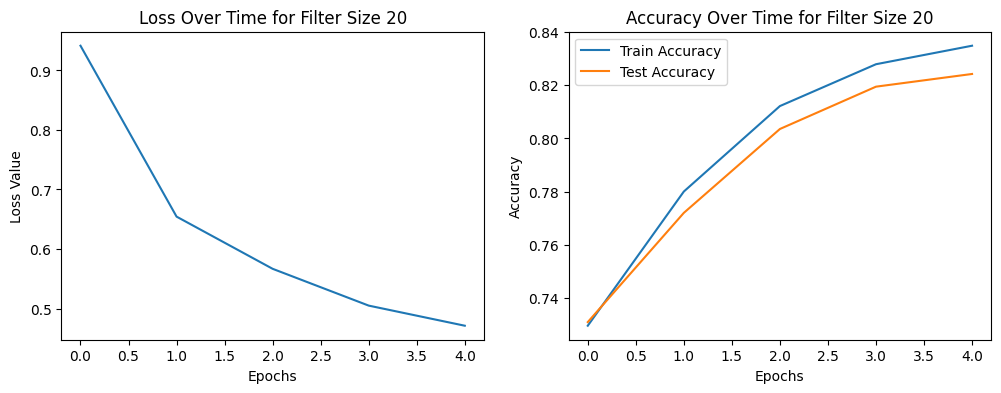

Running epoch 1 of 5
Running epoch 2 of 5
Running epoch 3 of 5
Running epoch 4 of 5
Running epoch 5 of 5
Total training time for Filter Size 25: 390.33016204833984
Number of parameters: 133110
Test accuracies: [0.7481091, 0.7825438, 0.80105495, 0.82971734, 0.83748007]


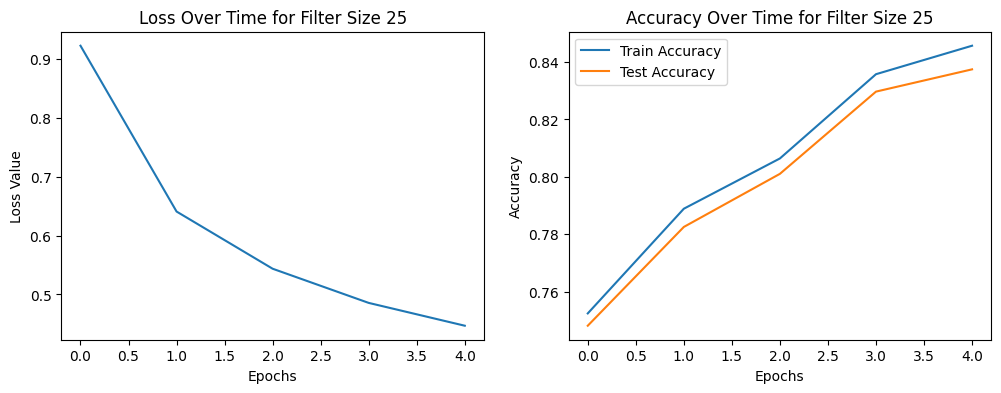

In [ ]:
# Part C
"""
For a fixed number of layers and kernel size in CNN, vary the number of filters per layer from 5, 10, 15, 20, 25 and compare the performance of the model and the training time
"""

for size in range(15, 26, 5):
  model = CNN(num_filters=size).to(device)
  loss_func = nn.CrossEntropyLoss().to(device)
  opt = Adam(model.parameters(), lr=1e-3)
  losses, is_accs, os_accs, training_time = train_model(model, 5, opt, loss_func)

  print(f"Total training time for Filter Size {size}: {training_time}")
  print(f"Number of parameters: {model.num_parameters()}")
  print(f"Test accuracies: {os_accs}")
  plot(losses, is_accs, os_accs,
       f"Loss Over Time for Filter Size {size}",
       f"Accuracy Over Time for Filter Size {size}",
       "Epochs", "Loss Value", "Accuracy"
  )


Running epoch 1 of 5
Running epoch 2 of 5
Running epoch 3 of 5
Running epoch 4 of 5
Running epoch 5 of 5


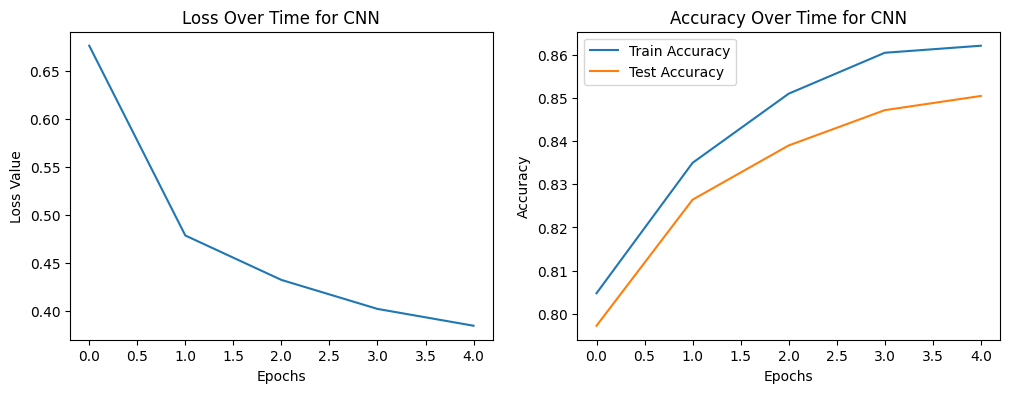

Run time: 396.7224814891815
CNN Parameters: 99010
Test accuracis: [0.7972731, 0.8264331, 0.8389729, 0.84713376, 0.850418]


In [ ]:
# Batch Normalization Test

# Set up model
class BNModel(nn.Module):

  def __init__(self):
    super().__init__()

    best_kernel = 5
    best_filters = 25
    self.cnn_stack = nn.Sequential(
      nn.Conv2d(1, best_filters, kernel_size=best_kernel),
      nn.BatchNorm2d(best_filters),  # BatchNorm2d after the first convolution
      nn.MaxPool2d(2),
      nn.ReLU(),
      nn.Conv2d(best_filters, best_filters, kernel_size=best_kernel),
      nn.BatchNorm2d(best_filters),  # BatchNorm2d after the second convolution
      nn.MaxPool2d(2),
      nn.ReLU(),
      nn.Flatten(),
      nn.Linear(best_filters * 4 * 4, 200),
      nn.BatchNorm1d(200),  # BatchNorm1d after the first linear layer
      nn.ReLU(),
      nn.Linear(200, 10)
  ).to(device)

  def forward(self, x):
    x = self.cnn_stack(x)
    return x

  def num_parameters(self):
    """Gets number of parameters"""
    return sum(p.numel() for p in self.parameters() if p.requires_grad)

  def train_batch(self, X_train, Y_train, opt, loss):
    self.train()
    opt.zero_grad()                    # Flush memory
    pred = self(X_train)
    batch_loss = loss(pred, Y_train)   # Compute loss
    batch_loss.backward()              # Compute gradients
    opt.step()                         # Make a GD step

    return batch_loss.detach().cpu().numpy()

  @torch.no_grad()
  def accuracy(self, x, y):
    self.eval()

    prediction = self(x)
    argmaxes = prediction.argmax(dim=1)
    s = torch.sum((argmaxes == y).float())/len(y)

    return s.cpu().numpy()


# Set up model, optimizer, and loss
model = BNModel()
loss_func = nn.CrossEntropyLoss().to(device)
opt = Adam(model.parameters(), lr=1e-3)

# Train for 5 epochs
losses, is_accs, os_accs, run_time = train_model(model, 5, opt, loss_func)

# Log results
plot(losses, is_accs, os_accs,
     f"Loss Over Time for CNN",
     f"Accuracy Over Time for CNN",
     "Epochs",
     "Loss Value",
     "Accuracy"
)
print(f"Run time: {run_time}")
print(f"CNN Parameters: {model.num_parameters()}")
print(f"Test accuracis: {os_accs}")


Running epoch 1 of 5
Running epoch 2 of 5
Running epoch 3 of 5
Running epoch 4 of 5
Running epoch 5 of 5


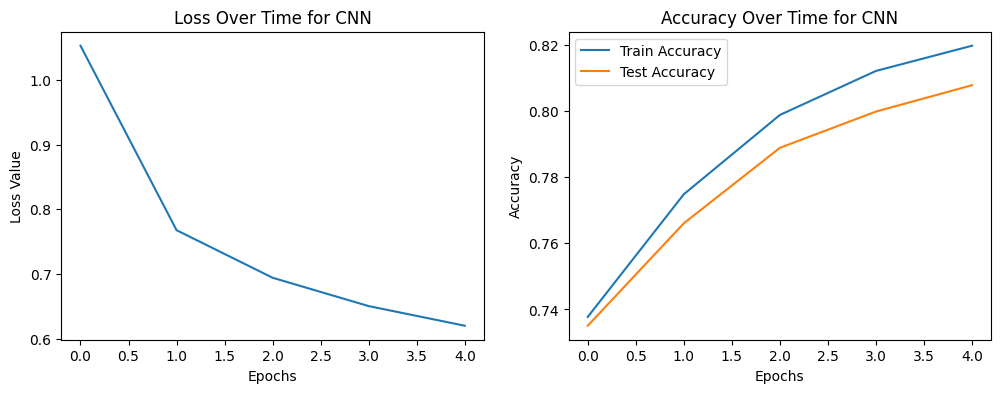

Run time: 402.88040113449097
CNN Parameters: 98510


In [ ]:
# Dropout Test

# Set up model
class DropoutModel(nn.Module):

  def __init__(self):
    super().__init__()

    best_kernel = 5
    best_filters = 25
    p = .5
    self.cnn_stack = nn.Sequential(
      nn.Conv2d(1, best_filters, kernel_size=best_kernel),
      nn.MaxPool2d(2),
      nn.ReLU(),
      nn.Dropout(p=p),  # Apply dropout after ReLU
      nn.Conv2d(best_filters, best_filters, kernel_size=best_kernel),
      nn.MaxPool2d(2),
      nn.ReLU(),
      nn.Dropout(p=p),  # Apply dropout after ReLU
      nn.Flatten(),
      nn.Linear(best_filters * 4 * 4, 200),
      nn.ReLU(),
      nn.Linear(200, 10)
  ).to(device)

  def forward(self, x):
    x = self.cnn_stack(x)
    return x

  def num_parameters(self):
    """Gets number of parameters"""
    return sum(p.numel() for p in self.parameters() if p.requires_grad)

  def train_batch(self, X_train, Y_train, opt, loss):
    self.train()
    opt.zero_grad()                    # Flush memory
    pred = self(X_train)
    batch_loss = loss(pred, Y_train)   # Compute loss
    batch_loss.backward()              # Compute gradients
    opt.step()                         # Make a GD step

    return batch_loss.detach().cpu().numpy()

  @torch.no_grad()
  def accuracy(self, x, y):
    self.eval()

    prediction = self(x)
    argmaxes = prediction.argmax(dim=1)
    s = torch.sum((argmaxes == y).float())/len(y)

    return s.cpu().numpy()


# Set up model, optimizer, and loss
model = DropoutModel()
loss_func = nn.CrossEntropyLoss().to(device)
opt = Adam(model.parameters(), lr=1e-3)

# Train for 5 epochs
losses, is_accs, os_accs, run_time = train_model(model, 5, opt, loss_func)

# Log results
plot(losses, is_accs, os_accs,
     f"Loss Over Time for CNN",
     f"Accuracy Over Time for CNN",
     "Epochs",
     "Loss Value",
     "Accuracy"
)
print(f"Run time: {run_time}")
print(f"CNN Parameters: {model.num_parameters()}")

In [ ]:
# Control

model = CNN(num_filters=25, kernel_size=5).to(device)
loss_func = nn.CrossEntropyLoss().to(device)
opt = Adam(model.parameters(), lr=1e-3)
losses, is_accs, os_accs, training_time = train_model(model, 5, opt, loss_func)

print(f"Total training time for Filter Size {size}: {training_time}")
print(f"Number of parameters: {model.num_parameters()}")
print(f"Test accuracies: {os_accs}")
plot(losses, is_accs, os_accs,
      f"Loss Over Time for Filter Size {size}",
      f"Accuracy Over Time for Filter Size {size}",
      "Epochs", "Loss Value", "Accuracy"
)

Running epoch 1 of 5
Running epoch 2 of 5
Running epoch 3 of 5
Running epoch 4 of 5
Running epoch 5 of 5


NameError: ignored

Total training time for Filter Size: 380.85987615585327
Number of parameters: 98510
Test accuracies: [0.75009954, 0.78383756, 0.8192675, 0.8231489, 0.8271298]


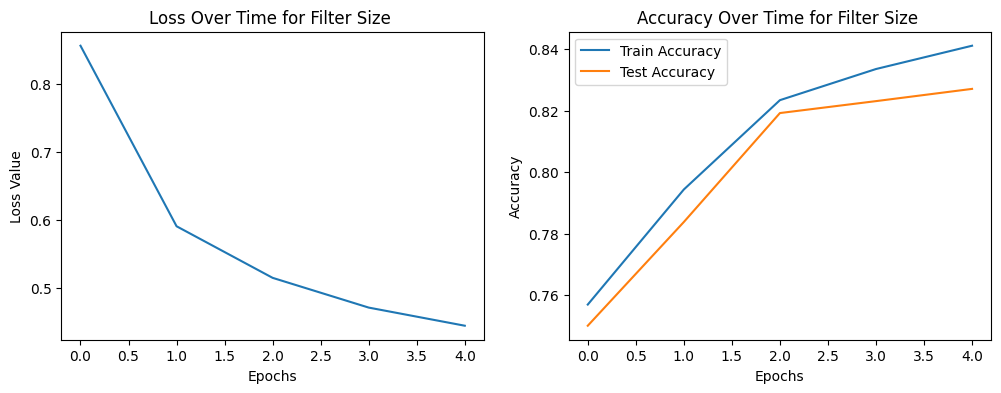

In [ ]:
print(f"Total training time for Filter Size: {training_time}")
print(f"Number of parameters: {model.num_parameters()}")
print(f"Test accuracies: {os_accs}")
plot(losses, is_accs, os_accs,
      f"Loss Over Time for Filter Size ",
      f"Accuracy Over Time for Filter Size ",
      "Epochs", "Loss Value", "Accuracy"
)